In [39]:
import os, sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

from Weighted_VP_model import *
sys.path.append(os.path.abspath('../Weighted_VP_model'))
sys.path.append(os.path.abspath('../tensorflow_WHVP_model'))
from data_handling import *

from vpnet import *
from vpnet.vp_functions import *
from spike_classification import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.ticker as mticker

import numpy as np
import matplotlib.pyplot as plt

from VPLayer import *
from XAIProject import *

In [2]:
dtype = torch.float64
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
window_size_ = 15
overlapping_size_ = 11

dataSet = NeurographyDataset()
path = f'window_{window_size_}_overlap_{overlapping_size_}_corrected.pkl'
dataSet.load_samples_and_labels_from_file(path)

dataloaders = dataSet.sequential_split_with_resampling()

n_channels, n_in = dataSet.samples[0].shape
n_out = len(dataSet.binary_labels_onehot[0])
hidden1 = 3
weight_num = 4
affin = torch.tensor([6 / n_in, -0.3606]).tolist()
#affin = torch.tensor([6 / n_in, -0.3606]).tolist()  #semioptimal
weight = ((torch.rand(weight_num)-0.5)*8).tolist()

model = VPNet(n_in, n_channels, hidden1, VPTypes.FEATURES, affin + weight, WeightedHermiteSystem(n_in, hidden1, weight_num), [hidden1], n_out, device=device, dtype=dtype)
model.load_state_dict(torch.load('trained_models/widnow_15_overlapping_11_hidden_3_nweight_4_id_2', weights_only=True))


c:\Users\darab\Documents\PROJECTS\VP_microneurography\code\data_handling.py:56: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_spike['track'] = all_spike['track'].replace(replacement_dict)


val timestamps shape (403573, 15)
val_samples shape torch.Size([403573, 1, 15])
class1 count 25000
class0 count 75000
Balanced shapes:  torch.Size([100000, 1, 15]) torch.Size([100000, 2]) torch.Size([100000, 4])
class1 count 25000
class0 count 75000
Balanced shapes:  torch.Size([100000, 1, 15]) torch.Size([100000, 2]) torch.Size([100000, 4])
Dataloaders are ready


<All keys matched successfully>

In [3]:
decision_boundary = 0.5
class_weights = torch.tensor([0.003, 0.997]).to(device)
weighted_criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
criterion = VPLoss(weighted_criterion, 0.1)
val_accuracy, val_loss, val_labels, val_predictions, val_probabilities = test(model, dataloaders['val_loader'], criterion, decision_boundary)
compute_metrics(val_labels, val_predictions)


Label 0:
  True Positives (TP): 0.0
  False Negatives (FN): 0.0
  False Positives (FP): 31396.0
  True Negatives (TN): 371410.0

Label 1:
  True Positives (TP): 259.0
  False Negatives (FN): 0.0
  False Positives (FP): 0.0
  True Negatives (TN): 0.0

Label 2:
  True Positives (TP): 254.0
  False Negatives (FN): 1.0
  False Positives (FP): 0.0
  True Negatives (TN): 0.0

Label 3:
  True Positives (TP): 226.0
  False Negatives (FN): 27.0
  False Positives (FP): 0.0
  True Negatives (TN): 0.0

Shape of all_multiple_labels: (403573,)
Val accuracy: 92.21%, loss: 19.1223
           MODEL METRICS          
Precision : 0.0230
Recall    : 0.9635
F1-Score  : 0.0449
       CONFUSION MATRIX           
              Predicted
          371410    31396
Actual    28    739
ROC-AUC   : 0.9428


In [4]:
val_all_samples = []
val_all_binary_labels = []
val_all_multiple_labels = []
for data in dataloaders['val_loader']:
    x, labels, multiple = data
    val_all_samples.append(x.cpu())
    val_all_binary_labels.append(labels.cpu())
    val_all_multiple_labels.append(multiple.cpu())
val_all_samples = torch.cat(val_all_samples).squeeze(1)
val_all_binary_labels = torch.cat(val_all_binary_labels)
val_all_multiple_labels = torch.cat(val_all_multiple_labels)
val_timestamps = dataloaders['val_timestamps']

In [42]:
print(val_labels.shape, val_predictions.shape, val_probabilities.shape, val_all_samples.shape)

torch.Size([403573]) torch.Size([403573]) torch.Size([403573, 2]) torch.Size([403573, 15])


In [11]:
#overlapping not handled
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

df = dataSet.all_differentiated_spikes
flattened_samples = val_all_samples.flatten()
print(flattened_samples.shape)

# Define the number of windows to plot at a time
windows_to_plot = 100
window_size = val_all_samples.shape[1]  # Number of points in each window

# Extract val_probabilities_class1 from the second column (corresponding to the class of interest)
val_probabilities_class1 = val_probabilities[:, 1]

# Define the color mapping based on 4 distinct categories
cmap = plt.get_cmap('tab10', 4)  # Using a colormap that supports 4 colors
color_bins = np.digitize(val_probabilities_class1 * 100, bins=np.linspace(0, 100, 5)) - 1  # 0-24%, 25-49%, 50-74%, 75-100%

# Define track colors
track_colors = {0: 'red', 1: 'green', 2: 'blue', 3: 'purple'}  # Ensure to include all track values

# Create a list of colors and percentage labels for the legend
percentage_labels = [f'{i * 25}-{(i + 1) * 25 - 1}%' for i in range(4)]  # Update for 4 categories
legend_elements = [Line2D([0], [0], marker='o', color='w', label=label, 
                          markerfacecolor=cmap(i), markersize=10) for i, label in enumerate(percentage_labels)]

# Add track legend elements
track_legend_elements = [Line2D([0], [0], color=track_colors[i], lw=2, label=f'Track {i}') for i in track_colors]

# Define the index of the first matching timestamp window
first_matching_index = 5947
first_matching_index = 15947

# Calculate the start index for plotting windows around the first matching index
start_index = max(0, first_matching_index - windows_to_plot // 2)  # Start plotting a few windows before the matching index
end_index = start_index + windows_to_plot  # Number of windows to plot

# Create a scatter plot for the windows around the first matching timestamp
plt.figure(figsize=(18, 6))

# Loop to plot windows in the defined range
for i in range(start_index, end_index):
    # Get the subset of windows to plot
    start = i * window_size
    window_end = start + window_size

    # Get the val_probabilities_class1 and corresponding color bin for the current window
    window_probabilities = val_probabilities_class1[i]
    window_colors = color_bins[i]
    
    # Scatter plot for this window
    plt.scatter(range(start, window_end),
                flattened_samples[start:window_end],
                c=[cmap(window_colors)] * window_size,  # Same color for all points in a window
                alpha=0.6, s=10)

    # Plot vertical lines based on dataframe timestamps and track values
    window_timestamps = val_timestamps[i:i + 1]  # Select the relevant window timestamps
    for _, row in df.iterrows():
        # Check if the timestamp from the dataframe is within the current window
        if row['ts'] >= window_timestamps.min() and row['ts'] <= window_timestamps.max():
            # Find the index of the timestamp in the window
            timestamp_index_within_window = np.argmin(np.abs(window_timestamps - row['ts']))
            global_index = start + timestamp_index_within_window
            # Plot the vertical line with the color corresponding to the track value
            plt.axvline(x=global_index, color=track_colors[int(row['track'])], linestyle='--', lw=2)  # Convert to int

# Add legends
plt.legend(handles=legend_elements + track_legend_elements, title="Probability (%) and Track", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title(f"Scatter Plot of Windows Around Index {first_matching_index}")
plt.xlabel('Sample index')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show(block=True)
plt.close()


torch.Size([6053595])


In [5]:
def reconstruct_original_sequence(overlapping_windows, window_size, overlapping):
    # Ensure the input is a NumPy array
    overlapping_windows = np.asarray(overlapping_windows)

    # Calculate the original length
    num_windows = len(overlapping_windows)
    stride = window_size - overlapping
    original_length = (num_windows - 1) * stride + window_size
    
    # Initialize an array to store the reconstructed sequence
    reconstructed_sequence = np.zeros(original_length)
    
    # Create an array to track how many times each index has been populated
    count_array = np.zeros(original_length)

    # Loop through the windows to reconstruct the sequence
    for i in range(num_windows):
        start_index = i * stride
        end_index = start_index + window_size
        
        # Add the window values to the appropriate positions in the reconstructed sequence
        reconstructed_sequence[start_index:end_index] += overlapping_windows[i]
        
        # Increment the count for the positions populated by this window
        count_array[start_index:end_index] += 1

    # Divide by the count to fill in the overlapping parts correctly
    non_zero_count_mask = count_array > 0
    reconstructed_sequence[non_zero_count_mask] /= count_array[non_zero_count_mask]
    
    # Fill NaN values if any (can happen at the beginning or end)
    reconstructed_sequence = np.nan_to_num(reconstructed_sequence)

    return reconstructed_sequence
original_val_samples = reconstruct_original_sequence(val_all_samples, 15, 11)
original_val_ts = reconstruct_original_sequence(val_timestamps, 15, 11)
original_val_samples.shape, original_val_ts.shape

((1614303,), (1614303,))

In [6]:
start_ts = original_val_ts[0]
end_ts = original_val_ts[-1]
df = dataSet.all_differentiated_spikes

# Find the first row index in df where 'ts' is greater than or equal to start_ts
start_index = dataSet.all_differentiated_spikes['ts'].searchsorted(start_ts, side='left')

# Find the last row index in df where 'ts' is less than or equal to end_ts
end_index = dataSet.all_differentiated_spikes['ts'].searchsorted(end_ts, side='right')

# Slice df to only include rows within the range of original_val_ts timestamps
val_gt_spikes = dataSet.all_differentiated_spikes.iloc[start_index:end_index]

In [7]:
first_ts_df_val_range = val_gt_spikes['ts'].iloc[0]

# Convert val_timestamps to a NumPy array if it isn't one already
val_timestamps_array = np.array(val_timestamps)

closest_index = np.argmin(np.abs(val_timestamps_array - first_ts_df_val_range))

# Retrieve the closest timestamp value for reference
closest_ts = val_timestamps_array[closest_index]
closest_index


80609

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.ticker as mticker

# Assuming dataloaders and original_val_ts are already defined
val_timestamps_np = np.array(val_timestamps)
len_orig_val = len(original_val_ts)
val_probabilities_class1 = val_probabilities[:, 1]


# Initialize a list to store the highest val_probabilities_class1
# Define the index of the first matching timestamp window
sample_size = 3000  # Number of windows to plot at a time
custom_colors =  ['#808080', '#C0C0C0', 'khaki', '#FFA500', '#FF0000'] # Adjust colors as needed

# Adjust bins for custom ranges
bins = [0, 25, 50, 80, 90, 100]  # Custom bin edges

# Set up labels for the new ranges
percentage_labels = ['0-25%', '25-50%', '50-80%', '80-90%', '90-100%']
legend_elements = [Line2D([0], [0], marker='o', color='w', label=label,
                          markerfacecolor=custom_colors[i], markersize=10) for i, label in enumerate(percentage_labels)]
track_colors = { 1: 'black', 2: '#04BFAD', 3: 'green'}

#for start_index in range(21300, 21300+sample_size*10, sample_size):
for start_index in range(171000, 171000+sample_size*10, sample_size):
    highest_probabilities = []
    end_index = start_index + sample_size
    # Get relevant timestamps and their corresponding val_probabilities_class1
    for ts in original_val_ts[start_index:end_index]:
        # Create a boolean mask for the current timestamp
        window_mask = np.any((val_timestamps_np == ts), axis=1)
        window_indices = np.where(window_mask)[0]

        if window_indices.size > 0:
            probs = val_probabilities_class1[window_indices].numpy()
            highest_probability = np.mean(probs)
        else:
            highest_probability = np.nan

        highest_probabilities.append(highest_probability)

    # Create a DataFrame to store the results
    df_orig = pd.DataFrame({
        'Timestamp': original_val_ts[start_index:end_index],
        'Samples': original_val_samples[start_index:end_index],
        'Probability': highest_probabilities
    })

    # Plotting
    plt.figure(figsize=(20, 6))

    # Define color bins based on val_probabilities_class1
    color_bins = np.digitize(df_orig['Probability'] * 100, bins=bins) - 1

    spike_labels = ['stimulus', 'Track3', 'Track4']
    track_legend_elements = [Line2D([0], [0], color=track_colors[i + 1], lw=2, label=spike_labels[i]) for i in range(len(spike_labels))]

    # Scatter plot for this window
    plt.scatter(df_orig['Timestamp'],
                df_orig['Samples'],
                c=[custom_colors[color_bins[i]] for i in range(len(color_bins))],  # Color according to bins
                alpha=0.6, s=10)

    # Add vertical lines based on DataFrame timestamps and track values
    window_timestamps = df_orig['Timestamp'].values
    print("Plotting range:", window_timestamps.min(), window_timestamps.max())
    filtered_df_val_range = val_gt_spikes[(val_gt_spikes['ts'] >= window_timestamps.min()) & 
                                     (val_gt_spikes['ts'] <= window_timestamps.max())]

    # Iterate over the filtered DataFrame
    y_top = df_orig['Samples'].max() * 1.1  # Slightly above the max sample value
    y_bottom = df_orig['Samples'].min() * 1.1
    for index, row in filtered_df_val_range.iterrows():
        color = track_colors.get(int(row['track']), 'black')  # Default to black if track color is not found
        
        # Plot a circle at the top position
        plt.scatter(row['ts'], y_top, color=color, s=100, alpha=0.8, edgecolor='black', linewidth=0.5)

        # Plot a circle at the bottom position
        plt.scatter(row['ts'], y_bottom, color=color, s=100, alpha=0.8, edgecolor='black', linewidth=0.5)
    #for index, row in filtered_df_val_range.iterrows():
        plt.axvline(x=row['ts'], color=track_colors[int(row['track'])], linestyle='--', lw=0.5)

    # Add legends
    plt.legend(handles=legend_elements + track_legend_elements, title="Probability and Track", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel('Timestamp')
    plt.ylabel('Amplitude')
    plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(nbins=50))  # Increase the number of x-ticks
    plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:.4f}'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show(block=True)
    plt.close()


Plotting range: 2502.787794082538 2503.087694082538
First spike timestamp in df_val_range: 2487.838394082541
Plotting range: 2503.087794082538 2503.387694082538
First spike timestamp in df_val_range: 2487.838394082541
Plotting range: 2503.3877940825378 2503.6876940825377
First spike timestamp in df_val_range: 2487.838394082541
Plotting range: 2503.687794082538 2503.987694082538
First spike timestamp in df_val_range: 2487.838394082541
Plotting range: 2503.9877940825377 2504.287694082538
First spike timestamp in df_val_range: 2487.838394082541


KeyboardInterrupt: 

In [8]:
Phi, _ = model.vp_layer.fun_system(model.vp_layer.params)
Phip = torch.linalg.pinv(Phi, rtol=1e-15)

In [9]:
val_all_samples.shape, Phip.shape

(torch.Size([403573, 15]), torch.Size([15, 3]))

In [10]:
val_all_samples = val_all_samples.to(device)
vplayer_output = val_all_samples @ Phip

In [11]:
vplayer_output.shape

torch.Size([403573, 3])

In [12]:
def create_tf_model_wo_VP():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(3,)),
        tf.keras.layers.Dense(3, activation=None, use_bias=True),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(2, activation=None, use_bias=True) 
    ])
    return model

In [13]:
torch_weights = torch.load('trained_models/widnow_15_overlapping_11_hidden_3_nweight_4_id_2', weights_only=True)
weights_fc1 = torch_weights['fcnn.1.weight'].cpu().numpy()
biases_fc1 = torch_weights['fcnn.1.bias'].cpu().numpy()

weights_fc2 = torch_weights['fcnn.3.weight'].cpu().numpy()
biases_fc2 = torch_weights['fcnn.3.bias'].cpu().numpy() 

weights_fc1_tf = np.transpose(weights_fc1)
weights_fc2_tf = np.transpose(weights_fc2)

In [14]:
tf_model_wo_tf_vp = create_tf_model_wo_VP()

tf_model_wo_tf_vp.layers[0].set_weights([weights_fc1_tf, biases_fc1])
tf_model_wo_tf_vp.layers[2].set_weights([weights_fc2_tf, biases_fc2])
tf_model_wo_tf_vp.compile(optimizer='adam', 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])

In [15]:
tf_model_wo_tf_vp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 12        
                                                                 
 re_lu (ReLU)                (None, 3)                 0         
                                                                 
 dense_1 (Dense)             (None, 2)                 8         
                                                                 
Total params: 20 (80.00 Byte)
Trainable params: 20 (80.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
def convert_to_class_labels(predictions):
    class_labels = np.argmax(predictions, axis=1)
    return class_labels

input_data_vp_output = vplayer_output

with torch.no_grad():
    pytorch_output = model.fcnn(input_data_vp_output).cpu().numpy() 

pytorch_labels = convert_to_class_labels(pytorch_output)

print("PyTorch output:\n", pytorch_labels[:10])

tf_input_data_vp_output = input_data_vp_output.cpu().detach().numpy().astype(np.float32)
tf_output = tf_model_wo_tf_vp.predict(tf_input_data_vp_output)
tf_labels = convert_to_class_labels(tf_output)

print("TensorFlow output:\n", tf_labels[:10])

correct_predictions = np.sum(pytorch_labels == tf_labels)
total_predictions = len(pytorch_labels)

accuracy = correct_predictions / total_predictions
print(f'Accuracy: {accuracy:.4f}')

PyTorch output:
 [0 0 0 0 0 0 0 0 1 1]


c:\Users\darab\anaconda3\envs\microneurography\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


TensorFlow output:
 [0 0 0 0 0 0 0 0 1 1]
Accuracy: 1.0000


In [17]:
import tensorflow as tf

HNUM = 3
VP_INIT = [1.0, -6.0]
WEIGHTS = np.random.uniform(-7, 2, weight_num)
VP_INIT.extend(list(WEIGHTS))
VP_PEN = 0.1
torch_weights = torch.load('trained_models/widnow_15_overlapping_11_hidden_3_nweight_4_id_2', weights_only=True)

def create_tf_model():
  keras_model = tf.keras.Sequential()
  keras_model.add(tf.keras.Input(shape=15))
  keras_model.add(VPLayer(15, HNUM, VP_INIT, VP_PEN, name='vplayer'))
  keras_model.add(tf.keras.layers.Dense(3, name='linear1'))
  keras_model.add(tf.keras.layers.ReLU())
  keras_model.add(tf.keras.layers.Dense(2, name='linear2'))
  #keras_model.add(tf.keras.layers.Softmax())

  keras_model.compile(optimizer="adam",
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

  return keras_model

keras_model = create_tf_model()



In [56]:
for key in torch_weights.keys():
    print(key)

vp_layer.params
fcnn.1.weight
fcnn.1.bias
fcnn.3.weight
fcnn.3.bias


In [18]:
weights_vp = torch_weights['vp_layer.params'].cpu().numpy()

weights_fc1 = torch_weights['fcnn.1.weight'].cpu().numpy()
biases_fc1 = torch_weights['fcnn.1.bias'].cpu().numpy()

weights_fc2 = torch_weights['fcnn.3.weight'].cpu().numpy()
biases_fc2 = torch_weights['fcnn.3.bias'].cpu().numpy() 

weights_fc1_tf = np.transpose(weights_fc1)
weights_fc2_tf = np.transpose(weights_fc2)

In [58]:
torch_weights['vp_layer.params']

tensor([ 0.2801, -0.5579,  0.7787,  2.1243, -1.8854, -1.3230], device='cuda:0',
       dtype=torch.float64)

In [19]:

num_weights = 6
weight_splits = np.split(weights_vp, num_weights)
keras_model.layers[0].set_weights(weight_splits)
keras_model.layers[1].set_weights([weights_fc1_tf, biases_fc1])
keras_model.layers[3].set_weights([weights_fc2_tf, biases_fc2])
keras_model.compile(optimizer='adam', 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])

In [60]:
for layer in keras_model.layers:
    layer_name = layer.name
    print(f"Layer: {layer_name}")
    weights = layer.get_weights()
    for weight in weights:
        print(weight)

Layer: vplayer
[0.280127]
[-0.5579473]
[0.7787106]
[2.1242588]
[-1.8853798]
[-1.322984]
Layer: linear1
[[ 3.1107457   1.309499    0.2513151 ]
 [ 0.53351456  0.5379464   0.6191417 ]
 [-0.47656617  0.8078334   3.2120104 ]]
[ 0.35207292  3.1023479  -1.1102382 ]
Layer: re_lu_6
Layer: linear2
[[-2.5946705  1.8449029]
 [ 2.903596  -2.643332 ]
 [-1.9347034  2.8234913]]
[-1.9412234  1.9875988]


In [61]:
for layer_name, weights in torch_weights.items():
    print(f"Layer: {layer_name}")
    print(weights.cpu().numpy()) 

Layer: vp_layer.params
[ 0.28012698 -0.55794726  0.77871061  2.12425873 -1.88537984 -1.32298402]
Layer: fcnn.1.weight
[[ 3.11074569  0.53351454 -0.47656617]
 [ 1.30949902  0.53794643  0.80783336]
 [ 0.25131508  0.61914169  3.21201029]]
Layer: fcnn.1.bias
[ 0.35207292  3.10234793 -1.11023822]
Layer: fcnn.3.weight
[[-2.59467058  2.90359604 -1.93470339]
 [ 1.8449029  -2.64333189  2.82349137]]
Layer: fcnn.3.bias
[-1.94122335  1.98759879]


In [62]:
val_all_samples.shape

torch.Size([403573, 15])

In [20]:
input_data = val_all_samples

with torch.no_grad():
    pytorch_output = model(input_data)[0].cpu().numpy() 

pytorch_labels = convert_to_class_labels(pytorch_output)

print("PyTorch output:\n", pytorch_labels[:10])

tf_input_data = input_data.cpu().detach().numpy().astype(np.float64)
keras_output = keras_model.predict(tf_input_data)
tf_labels = convert_to_class_labels(keras_output)

print("TensorFlow output:\n", tf_labels[:10])

correct_predictions = np.sum(pytorch_labels == tf_labels)
total_predictions = len(pytorch_labels)

accuracy = correct_predictions / total_predictions
print(f'Accuracy: {accuracy:.4f}')

PyTorch output:
 [0 0 0 0 0 0 0 0 1 1]
TensorFlow output:
 [0 0 0 0 0 0 0 0 1 0]
Accuracy: 0.9196


In [65]:
np.sum(pytorch_labels == 1)

32135

In [66]:
np.sum(tf_labels == 1)

20861

In [60]:
tf_output[:10]

array([[ 3.8455992 , -4.8461037 ],
       [ 5.5370326 , -3.7812693 ],
       [ 6.152407  , -5.2635956 ],
       [ 5.7775736 , -4.927224  ],
       [ 8.982389  , -7.8031864 ],
       [ 2.6968274 , -2.1625993 ],
       [ 7.405503  , -7.670599  ],
       [ 4.7863307 , -4.037694  ],
       [-1.1407676 , -0.38125205],
       [ 1.235785  ,  5.9702873 ]], dtype=float32)

In [61]:
pytorch_output[:10]

array([[9.99783542e-01, 2.16458074e-04],
       [9.99948112e-01, 5.18878370e-05],
       [9.99999558e-01, 4.42399625e-07],
       [9.99999776e-01, 2.24034363e-07],
       [9.98594573e-01, 1.40542651e-03],
       [9.99999821e-01, 1.78750399e-07],
       [9.88008913e-01, 1.19910869e-02],
       [9.99851220e-01, 1.48779716e-04],
       [1.28128485e-01, 8.71871515e-01],
       [6.08623950e-02, 9.39137605e-01]])

In [21]:
import innvestigate
integrated_gradient_analyzer_fe = innvestigate.create_analyzer("integrated_gradients", tf_model_wo_tf_vp, neuron_selection_mode="max_activation",reference_inputs=0, steps = 64)
analyzation_fe = integrated_gradient_analyzer_fe.analyze(tf_input_data_vp_output)

In [22]:
analyzation_fe.shape

(403573, 3)

In [23]:

integrated_gradient_analyzer_full = innvestigate.create_analyzer("integrated_gradients", keras_model, neuron_selection_mode="max_activation",reference_inputs=0, steps = 64)
analyzation_full = integrated_gradient_analyzer_full.analyze(tf_input_data)

In [24]:
analyzation_full.shape

(403573, 15)

In [25]:
val_all_binary_labels_np = val_all_binary_labels.numpy()
val_all_multiple_labels_np = val_all_multiple_labels.numpy()

In [26]:
feature_extractor_XAIProject = XAIProject(model=tf_model_wo_tf_vp,
                                          samples=tf_input_data_vp_output,
                                          binary_labels=val_all_binary_labels_np,
                                          multiple_labels=val_all_multiple_labels_np,
                                          probabilities=tf_output)

In [27]:
feature_extractor_XAIProject.analyzer_output = analyzation_fe

In [67]:
keras_output[:10]

array([[ 1.4843118 , -2.8855534 ],
       [ 5.9976816 , -5.239702  ],
       [ 5.442461  , -5.0332503 ],
       [ 5.860338  , -5.318806  ],
       [ 6.335614  , -4.869083  ],
       [ 2.9511364 , -2.4662342 ],
       [ 3.0921476 , -3.3298616 ],
       [ 0.7751243 , -0.48526895],
       [-3.991378  ,  0.9197267 ],
       [ 3.0859668 ,  0.9292077 ]], dtype=float32)

In [28]:
full_extractor_XAIProject = XAIProject(model=keras_model,
                                          samples=tf_input_data,
                                          binary_labels=val_all_binary_labels_np,
                                          multiple_labels=val_all_multiple_labels_np,
                                          probabilities=keras_output)
full_extractor_XAIProject.analyzer_output = analyzation_full

In [35]:
len(full_extractor_XAIProject.get_truth_class_multiple_indices_for_class(1))

259

In [38]:
"""
print the original input data
"""
class_0_indices = full_extractor_XAIProject.get_truth_class_binary_indices_for_class(0)
class_1_indices = full_extractor_XAIProject.get_truth_class_multiple_indices_for_class(3)
inputs_class_0 = full_extractor_XAIProject.samples[class_0_indices[::10000]]
inputs_class_1 = full_extractor_XAIProject.samples[class_1_indices[::50]]

fig, ax = plt.subplots(figsize=(12, 6))

for row in inputs_class_1:
    ax.plot(row, color="lime", linestyle="--", linewidth = 1, label = "Class 1")
for row in inputs_class_0:
    ax.plot(row, color="red", linestyle="--", linewidth = 1,  label = "Class 0")

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())
ax.set_xlabel("Time (s)")
ax.set_ylabel("Voltage (mV)")
plt.show()

In [63]:
import random
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches

def create_comparison_plot(project : XAIProject, binary_class_num, multiple_class_num, prediction_quality, random_, average_sample, average_analyzer):
    """
    project: BinaryProject() instance that holds the analyzation

    class_num: the id of the class which should be shown on the plots

    prediction_quality: correct, incorrect, false_negative or false_positive in string format
    
    random_: boolean that shows if randomized single inputs should be shown on the plot
    
    average_sample: boolean that shows if the averaged original recording should be shown on the plot
    
    average_analyzer: boolean that shows if the averaged relevance scores shoul be shown on the plot

    """
    if prediction_quality == "correct": #
        if binary_class_num != 0 and multiple_class_num:
            indices_for_class = project.get_true_positive_indices_for_multiple_class(multiple_class_num)
        else:
            indices_for_class = project.get_true_pos_prediction_indices_for_class(binary_class_num)
        title = "Correct predictions"
    elif prediction_quality == "incorrect":
        indices_for_class = project.get_incorrect_prediction_indices_for_class(binary_class_num)
        title = "Incorrect predictions"
    elif prediction_quality == "false_negative": #
        indices_for_class = project.get_false_negative_indices_for_class(binary_class_num)
        title = "False negative predictions"
    elif prediction_quality == "false_positive":
        indices_for_class = project.get_false_positive_indices_for_class(binary_class_num)
        title = "False positive predictions"
    
    input_for_class = project.samples[indices_for_class]
    analyzer_for_class = project.analyzer_output[indices_for_class]
    analyzer_class_mean = np.mean(analyzer_for_class, axis=0, keepdims=True)
    input_class_mean = np.mean(input_for_class, axis=0, keepdims=True)

    if input_for_class.shape[0] == 0:
        return
    if random_ == True:
        random_indice_to_plot = random.sample(range(input_for_class.shape[0]), 1)[0]

    blue = (0 / 255, 139 / 255, 139 / 255)
    red = (139 / 255, 0 / 255, 0 / 255)
    num_steps = 256
    colors = [blue, (0.82745, 0.82745, 0.82745) ,red]

    custom_cmap = LinearSegmentedColormap.from_list("custom_colormap", colors, N=num_steps)

    fig = plt.figure(figsize=(12,6))

    ax = fig.add_subplot(111)
    avg_re = avg_an = single_legend = None
    if binary_class_num == 0:
        c = blue
    else:
        c = red
    if average_sample == True:
        #y = upsample(normalize(input_class_mean[0,:], -1, 1),5)
        y = upsample(input_class_mean[0,:],5)
        x = range(len(y))
        ax.scatter(x, y, color=c, label="Input mean", s=3)
        avg_re = plt.Line2D([0], [0], color=c, linewidth=3, label='Recording mean')
    if average_analyzer == True:
        #y = upsample(normalize(analyzer_class_mean[0,:], -1, 1),5)
        y = upsample(analyzer_class_mean[0,:],5)
        x = range(len(y))
        ax.scatter(x, y, color="dimgray", label="Analyzer mean", s=3)
        avg_an = plt.Line2D([0], [0], color="dimgray", linewidth=3, label='Analyzer mean')
    if random_ == True:
        #color_base = upsample(normalize(analyzer_for_class[random_indice_to_plot,:], -1, 1),5)
        #y = upsample(normalize(input_for_class[random_indice_to_plot,:], -1, 1), 5)
        color_base = upsample(analyzer_for_class[random_indice_to_plot,:],5)
        y = upsample(input_for_class[random_indice_to_plot,:], 5)
        x = range(len(y))
        cmap = plt.get_cmap(custom_cmap)
        norm = plt.Normalize(-1, 1)
        line_colors = cmap(norm(color_base))
        ax.scatter(x, y, color=line_colors, label="Single input", s=4)
        sm = ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax)
        cbar.set_label('Analyzer value')
        single_legend = plt.Line2D([0], [0], color=blue, linewidth=4, label='Single recording')

    ax.set_xlim([0, len(y)])
    current_ticks = ax.get_xticks()
    adjusted_labels = current_ticks / 5
    ax.set_xticklabels([f"{int(label)}" for label in adjusted_labels])

    # for h_line in np.arange(-1,1.25,0.5):
    #     ax.axhline(y = h_line, color = "gray", linestyle = "dashed", linewidth = 0.25)

    # extra rectangle
    rect = patches.Rectangle((500, -1), 1500, 2, linewidth=1, edgecolor='orange', facecolor='none')
    ax.add_patch(rect)

    handle = [line for line in [avg_re, avg_an, single_legend] if line is not None]
    ax.legend(handles=handle, loc='upper right', fontsize=14)
    #ax.set_yticks(np.arange(-1, 1.25, 0.25))
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Time", fontsize=12)
    ax.set_ylabel("Normalized voltage", fontsize=12)
    fig.tight_layout()

C:\Users\darab\AppData\Local\Temp\ipykernel_15328\1792273464.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(label)}" for label in adjusted_labels])
C:\Users\darab\AppData\Local\Temp\ipykernel_15328\1792273464.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(label)}" for label in adjusted_labels])
C:\Users\darab\AppData\Local\Temp\ipykernel_15328\1792273464.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(label)}" for label in adjusted_labels])
C:\Users\darab\AppData\Local\Temp\ipykernel_15328\1792273464.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_

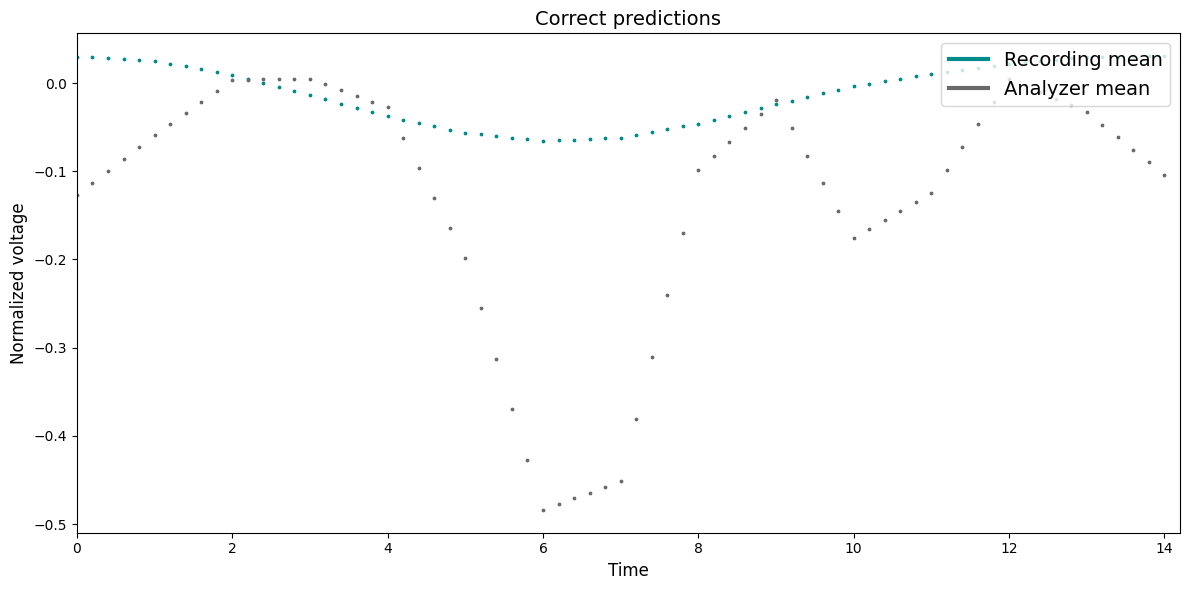

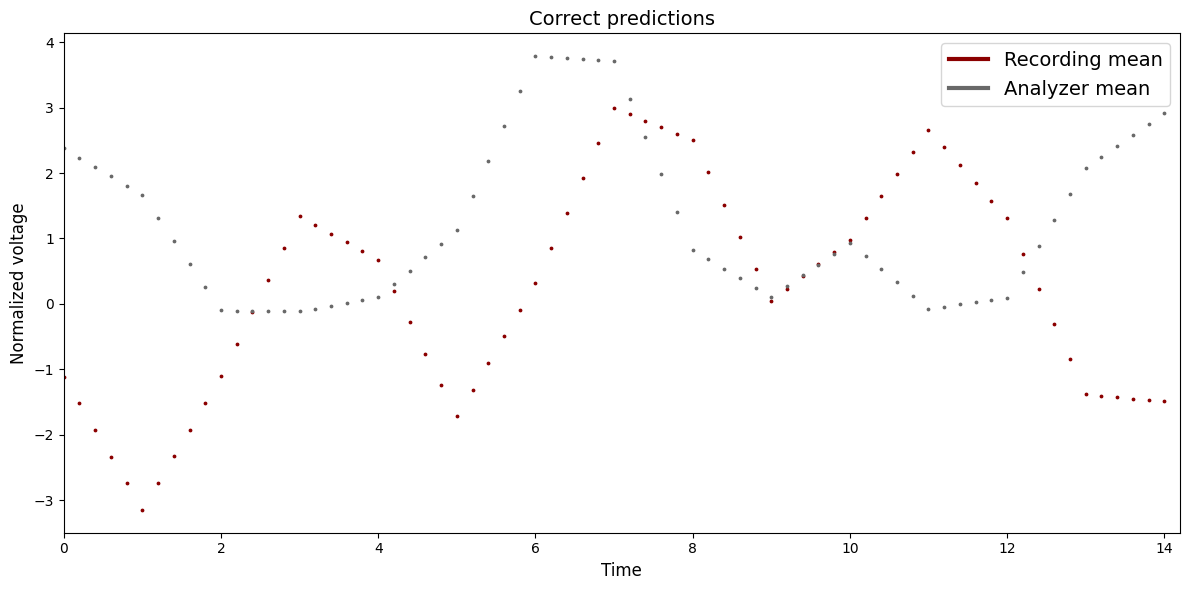

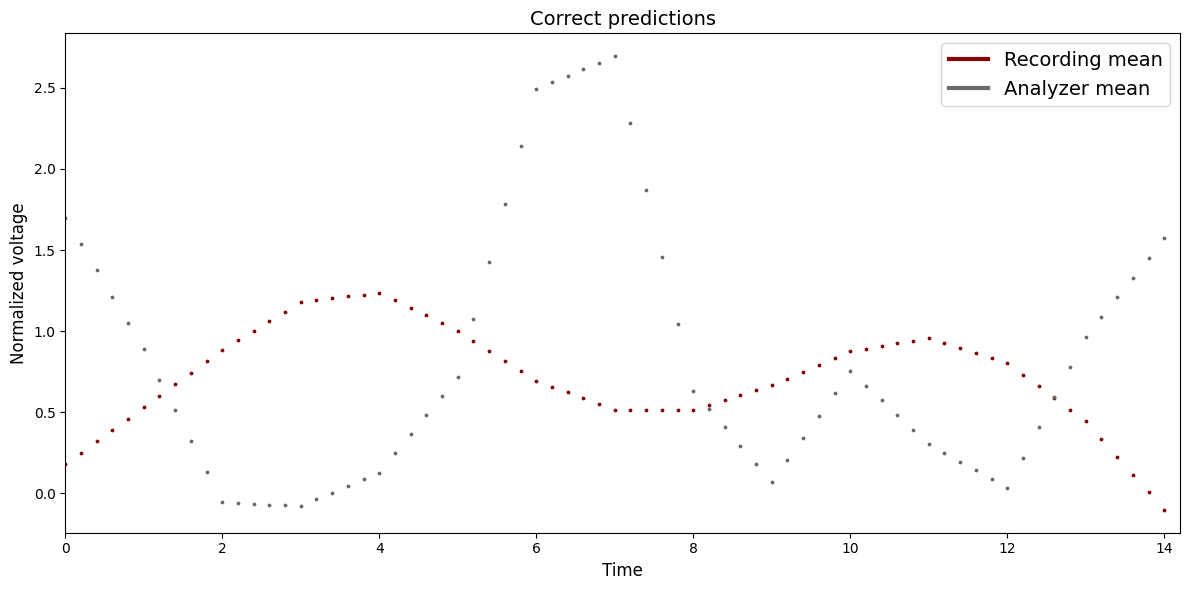

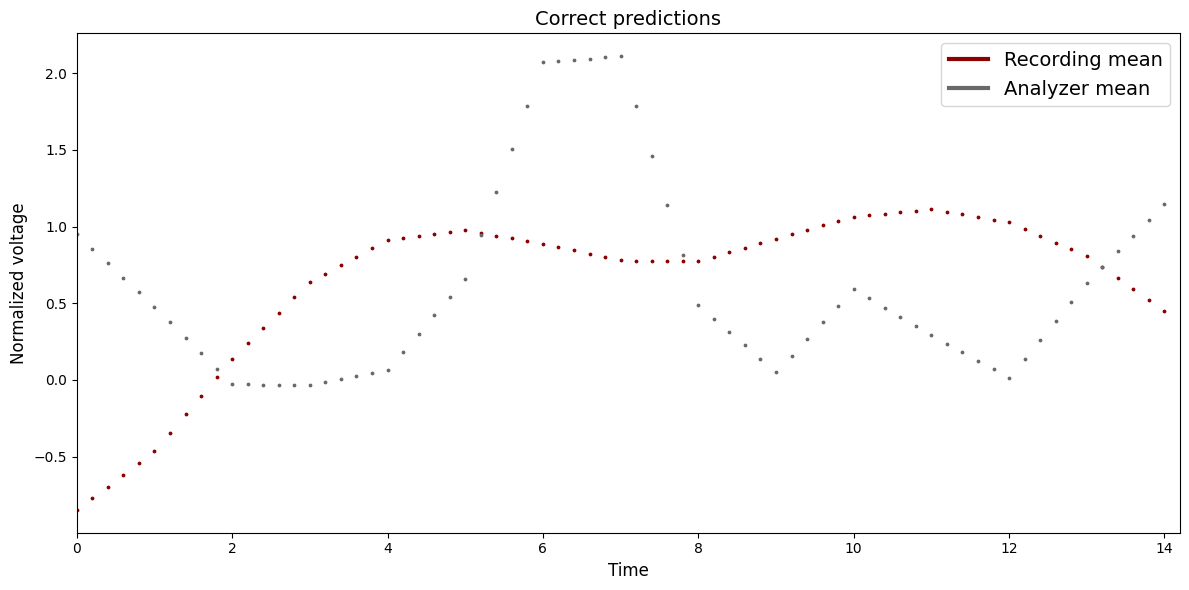

In [64]:
create_comparison_plot(full_extractor_XAIProject, binary_class_num = 0, multiple_class_num=False, prediction_quality = "correct", random_ = False, average_sample = True, average_analyzer = True)
create_comparison_plot(full_extractor_XAIProject, binary_class_num = 1, multiple_class_num=1, prediction_quality = "correct", random_ = False, average_sample = True, average_analyzer = True)
create_comparison_plot(full_extractor_XAIProject, binary_class_num = 1, multiple_class_num=2, prediction_quality = "correct", random_ = False, average_sample = True, average_analyzer = True)
create_comparison_plot(full_extractor_XAIProject, binary_class_num = 1, multiple_class_num=3, prediction_quality = "correct", random_ = False, average_sample = True, average_analyzer = True)

C:\Users\darab\AppData\Local\Temp\ipykernel_15328\1792273464.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(label)}" for label in adjusted_labels])
C:\Users\darab\AppData\Local\Temp\ipykernel_15328\1792273464.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(label)}" for label in adjusted_labels])
C:\Users\darab\AppData\Local\Temp\ipykernel_15328\1792273464.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(label)}" for label in adjusted_labels])
C:\Users\darab\AppData\Local\Temp\ipykernel_15328\1792273464.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_

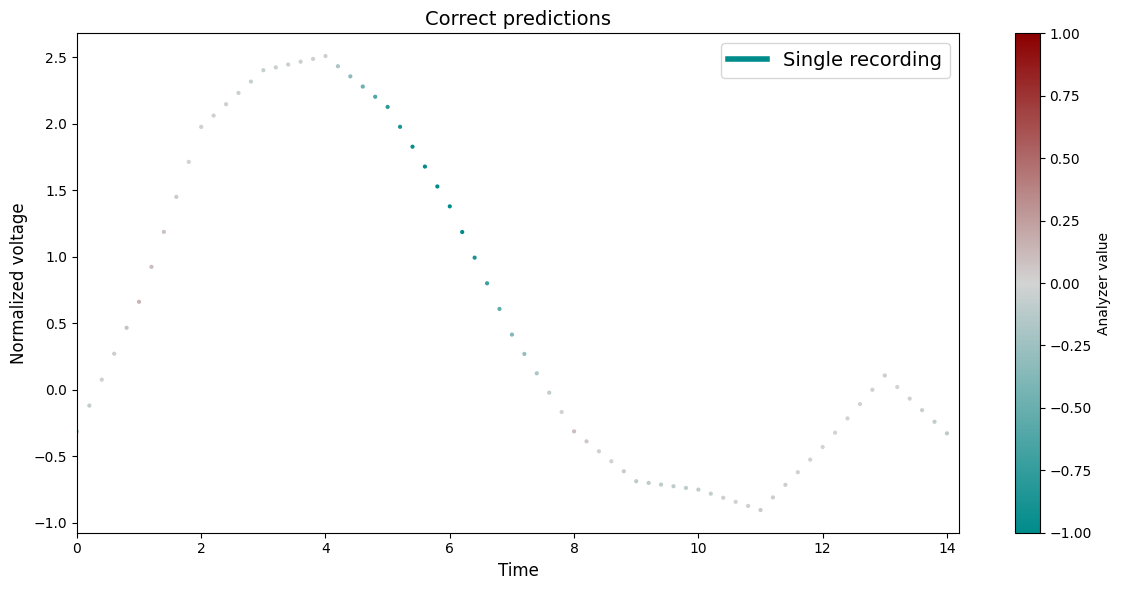

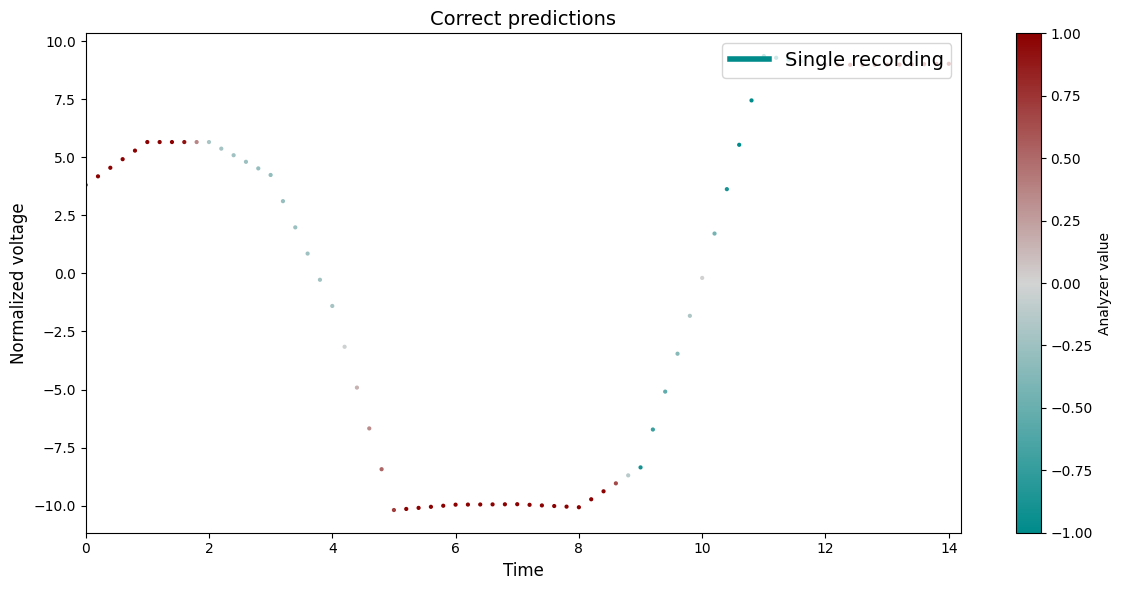

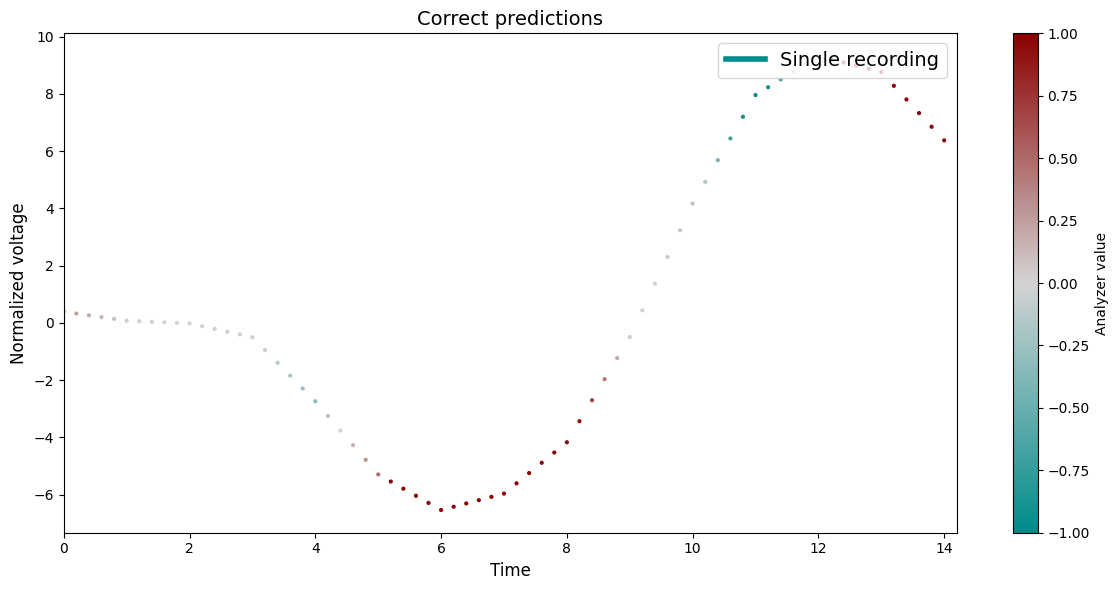

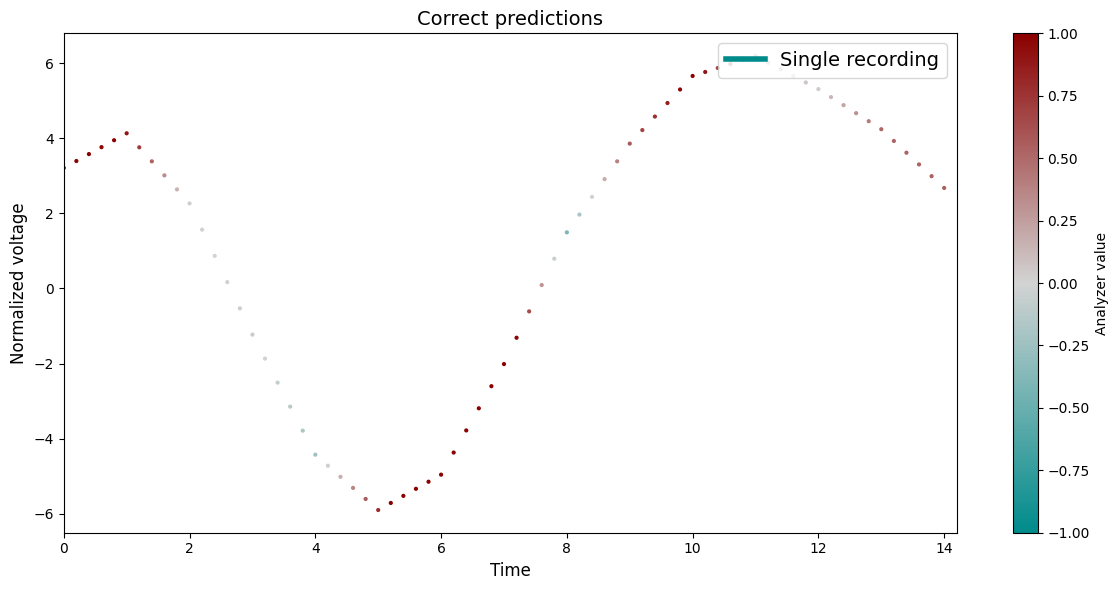

In [65]:
create_comparison_plot(full_extractor_XAIProject, binary_class_num = 0, multiple_class_num=False, prediction_quality = "correct", random_ = True, average_sample = False, average_analyzer = False)
create_comparison_plot(full_extractor_XAIProject, binary_class_num = 1, multiple_class_num=1, prediction_quality = "correct", random_ = True, average_sample = False, average_analyzer = False)
create_comparison_plot(full_extractor_XAIProject, binary_class_num = 1, multiple_class_num=2, prediction_quality = "correct", random_ = True, average_sample = False, average_analyzer = False)
create_comparison_plot(full_extractor_XAIProject, binary_class_num = 1, multiple_class_num=3, prediction_quality = "correct", random_ = True, average_sample = False, average_analyzer = False)